# Autoencodeur convolutif avec API

au debut inspiré par keras.io, exemple de Santiago Valdamara.m

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from keras import Input, layers
from keras.datasets import mnist
from keras.models import Model   # model géneral, pas forcement sequentiel(!)
# notre modèle sera a "geometrique variable"

In [3]:
def preprocess(tab):
    """ transformation des images en un tableau à valeur normaliséee"""
    # pour un réseau de neurones, il faut que l'entrée soit dans [0, 1]
    # (ou [-1, 1], concenré autour de 0, selon les fonctions d'activations).
    tab = tab.astype('float32') / 255
    tab = tab.reshape(len(tab), 28, 28, 1)  # on rajoute l'axe des couleurs pour la couche de convolution
    return tab

In [24]:
def noise(tab):
    """Rajoute du bruit gaussien a un tableau"""
    intensite = 0.4
    noisy_tab = tab + intensite*np.random.normal(loc=0.0, scale=1.0, size=tab.shape)
    return noisy_tab

In [26]:
def display(tab1, tab2):
    """ Affiche 10 images (au hasard) en deux lignes, à partir de tab1 et tab2"""
    n = 10
    indices = np.random.randint(len(tab1), size=n)
    plt.figure(figsize=(16,4))
    # iteration sur les deux tableaux à la fois , avec numérotation enumerate (dans variable i)
    # zip : fusion de deux tableaux comme fermeture éclair (non zip de compression)
    # tab1.shape est par exemple (60000, 28, 28)
    for i, (image1, image2) in enumerate(zip(tab1[indices, :, :], tab2[indices, :, :])):
        ax = plt.subplot(2, n, i+1)  # grille de 2 lignes n colonnes
        plt.imshow(image1.reshape(28, 28), cmap='winter')
        ax.get_xaxis().set_visible(False)  # cacher le repere
        ax.get_yaxis().set_visible(False)
        # deuxieme ligne
        ax = plt.subplot(2, n, i+1+n)
        plt.imshow(image2.reshape(28, 28), cmap='winter')
        ax.get_xaxis().set_visible(False)  # cacher le repere
        ax.get_yaxis().set_visible(False)
    plt.show()

In [28]:
# chargement de donnée
#ici pour un auto-encodeur on n'a pas besoin d'etiquettes
# (on parle d'apprentissage auto-supervisé)
(train_data, _), (test_data, _) = mnist.load_data()
X_train = preprocess(train_data)
X_test = preprocess(test_data)

# dataset bruité
X_noisy_train = noise(X_train)
X_noisy_test = noise(X_test)

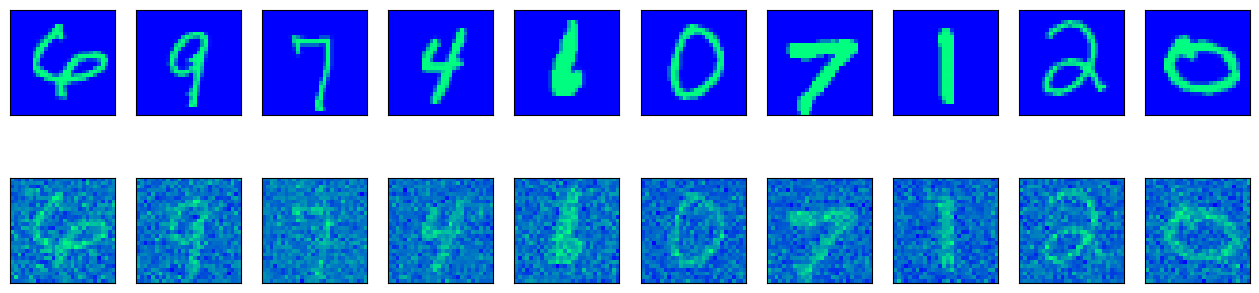

In [30]:
display(X_train, X_noisy_train)

## fonctional API 

Ecriture fonctionnelle : elle permet de creer des modèles plus complexes qu'une suite de couches.

In [32]:
input = Input(shape=(28, 28, 1))

# Encodeur
x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(input)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
X = layers.Conv2D(32, (3,3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
#  à la fin, la variable x indique la sortie d'encodeur 

In [34]:
# Decodeur
y = layers.Conv2DTranspose(32, (3, 3), strides=2, activation='relu', padding='same')(x)
# Conv2D est l'operation inverse de Conv+Maxpool, c.a.d elle aggrandi l'image d'entree (et la lisse)
# (c'est ce qu'on fait par definition pour auto-encodeur)
y = layers.Conv2DTranspose(32, (3,3), strides=2, activation='relu', padding='same')(y)
# sortie : une seule image a la sortie
y = layers.Conv2D(1, (3,3), activation='sigmoid', padding='same')(y)

In [36]:
# l'objet de Model est une sorte d'emballage qui permet a fonctionner un ensemble de couche 
# c'est dans le Model ou on precise le point d'entree et la sortie du reseau.
# en ce moment cela parait evident (ou est entrée et sortie)
# mais on peut construire des architectures a branchement avec plusieurs points d'entree, sortie et des bifuraction du trajey.
# en fait , un reseau est UN GRAPHE
autoencodeur = Model(input, y)

In [38]:
autoencodeur.compile(optimizer='adam', loss='binary_crossentropy')

In [40]:
autoencodeur.summary()
# espace latent : 32 petites images de taille 7x7

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 14, 14, 32)     │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 32)     │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,105 (74.63 KB)

 Trainable params: 19,105 (74.63 KB)

 Non-trainable params: 0 (0.00 B)

In [42]:
autoencodeur.fit(x=X_train, 
                y=X_train, # auto-supervisé
                epochs=10,
                batch_size=512)

Epoch 1/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 11s 86ms/step - loss: 0.5141
Epoch 2/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 10s 87ms/step - loss: 0.1061
Epoch 3/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 10s 86ms/step - loss: 0.0894
Epoch 4/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - loss: 0.0837
Epoch 5/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 11s 95ms/step - loss: 0.0808
Epoch 6/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - loss: 0.0789
Epoch 7/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 10s 85ms/step - loss: 0.0776
Epoch 8/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 10s 85ms/step - loss: 0.0764
Epoch 9/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 10s 87ms/step - loss: 0.0755
Epoch 10/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 11s 90ms/step - loss: 0.0747


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


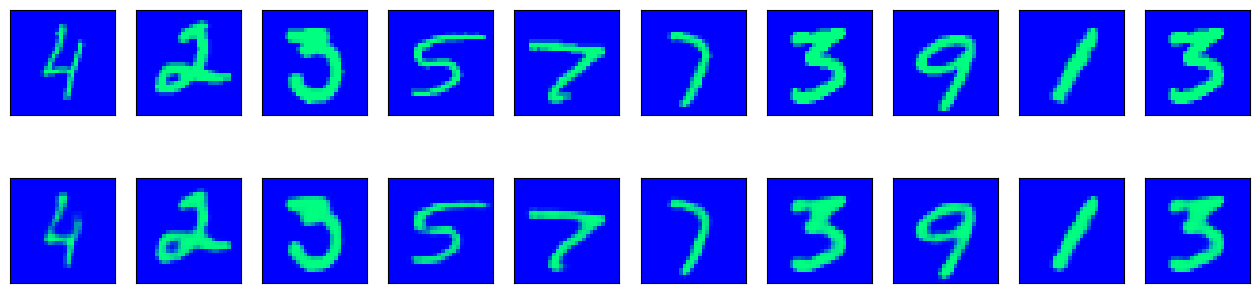

In [69]:
predictions = autoencodeur.predict(X_test)
display(X_test, predictions)

In [73]:
#autoencodeur.save("autoencodeur_jeudi_12.keras")

In [46]:
from keras.models import load_model
autoencoder = load_model("autoencodeur_jeudi_12.keras")

# Débruitage
Maintenant quand on sait que notre autoencodeur fonctionne, on va l'adapter a la tache de debruitage.

Le procédé s'appelle finetunning/peaufinage : on prend un modele "generaliste" entrainé sans aucune tache particulière comme cible,
et on l'ajuste d'avantage a un domaine / une tache specifique.

In [62]:
autoencoder.fit(x=X_noisy_train,
                y=X_train,
                epochs=7,
                batch_size=512)

Epoch 1/7
118/118 ━━━━━━━━━━━━━━━━━━━━ 11s 90ms/step - loss: 0.1074
Epoch 2/7
118/118 ━━━━━━━━━━━━━━━━━━━━ 11s 91ms/step - loss: 0.1070
Epoch 3/7
118/118 ━━━━━━━━━━━━━━━━━━━━ 11s 90ms/step - loss: 0.1066
Epoch 4/7
118/118 ━━━━━━━━━━━━━━━━━━━━ 11s 91ms/step - loss: 0.1063
Epoch 5/7
118/118 ━━━━━━━━━━━━━━━━━━━━ 11s 92ms/step - loss: 0.1058
Epoch 6/7
118/118 ━━━━━━━━━━━━━━━━━━━━ 11s 92ms/step - loss: 0.1056
Epoch 7/7
118/118 ━━━━━━━━━━━━━━━━━━━━ 11s 94ms/step - loss: 0.1052


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


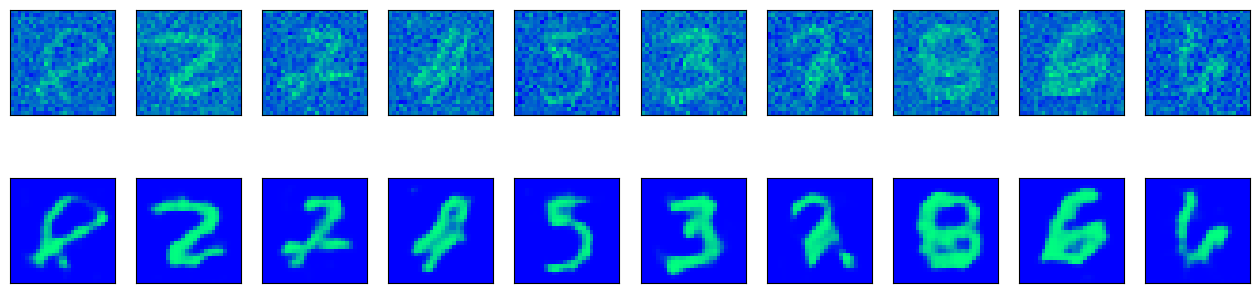

In [60]:
pred2 = autoencoder.predict(X_noisy_test)
display(X_noisy_test, pred2)

## Anatomie et neurochirugie
Transfer Learning : profiter d'un entrainement achevé d'un "généraliste" et l'utiliser avec une tête de classification
(un nouveau réseau, ici du type dense) spécifique a une tâche (ici une classification)

Rq. Transfer Learning est un terme un peu ambigue, cela peut signifier aussi un transfert de compétence d'un réseau d'un domaine a l'autre

In [64]:
# Bloc de classification 
c = layers.Flatten()(x)   # dans x a la derniere couche MaxPool
c = layers.Dense(64, activation='relu')(c)
c = layers.Dense(32, activation='relu')(c)
c = layers.Dense(10, activation='softmax')(c)

In [66]:
cls = Model(input,c)
cls.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1568)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       100,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,146 (402.91 KB)

 Trainable params: 103,146 (402.91 KB)

 Non-trainable params: 0 (0.00 B)

### Remarque:

Comment profiter du fait que l'autoencodeur a deja appris une bonne représentation ?
(Comment profiter d'une "base de connaissances"). Autrement dit, comment préserver les poids dans les couches convolutionnelle deja ajuste?)

In [69]:
cls.layers[1].trainable  # 1 couche convo, elle est "trainable"

True

In [71]:
# Geler les couches CNN
cls.layers[1].trainable=False
cls.layers[3].trainable=False
# Rq pas de parametre a apprendre dans les MaxPool, pas la peine de les geler

In [73]:
# Maintenant on passe a l'apprentissage supervisé, on aura besoin d'etiquettes
(train_data, train_labels), (test_data, test_labels) = mnist.load_data()

### Remarque
Normalement, on devrait convertir les labels vers la representation one-hot (`to_categorical`)

Mais Keras propose un outil qui le fait automatiquement (`sparse_categorical_crossentropy`):
il s'agit d'une fonction de perte qui accepte les entiers pour comme variable cible(et les transforme en one-hot a l'interne)

In [76]:
cls.compile(loss="sparse_categorical_crossentropy",   # CHEAT CODE
            optimizer='adam',
            metrics=['accuracy'])

In [78]:
train_labels[:10]   # oui, c'est des entiers

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=uint8)

In [82]:
cls.fit(x=X_train,
        y=train_labels,
        epochs=15,
        batch_size=512,
        validation_data=(X_test, test_labels))
# plus d'epochs, apprentissage pourtant assez rapide car les couches Con2D ont ete geles

Epoch 1/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9822 - loss: 0.0569 - val_accuracy: 0.9730 - val_loss: 0.0844
Epoch 2/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9807 - loss: 0.0630 - val_accuracy: 0.9767 - val_loss: 0.0711
Epoch 3/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9840 - loss: 0.0550 - val_accuracy: 0.9764 - val_loss: 0.0717
Epoch 4/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9845 - loss: 0.0527 - val_accuracy: 0.9782 - val_loss: 0.0659
Epoch 5/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9847 - loss: 0.0509 - val_accuracy: 0.9798 - val_loss: 0.0619
Epoch 6/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9835 - loss: 0.0532 - val_accuracy: 0.9793 - val_loss: 0.0615
Epoch 7/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9866 - loss: 0.0460 - val_accuracy: 0.9780 - val_loss: 0.0695
Epoch 8/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9857 - loss: 0.0462 - val_accuracy: 0.

In [84]:
score = cls.evaluate(X_test, test_labels)
print(score)    # accuracy = score[1]

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step - accuracy: 0.9787 - loss: 0.0684
[0.057027485221624374, 0.9819999933242798]


### Remarque 

Notre résultat (acc) n'est pas forcement meilleur que l'autre fois avec un réseau CNN dédie
exclusivement a la classification (acc=0.992).Mais maintenant notre tronc commun d'encodeur est plus "generaliste": il peut servir a des fins
differents

# Anatomie

Analyse de reseau, comment acceder aux poids et aux activations a l'interieur ?

In [89]:
cls.layers

[<InputLayer name=input_layer, built=True>,
 <Conv2D name=conv2d, built=True>,
 <MaxPooling2D name=max_pooling2d, built=True>,
 <MaxPooling2D name=max_pooling2d_1, built=True>,
 <Flatten name=flatten, built=True>,
 <Dense name=dense, built=True>,
 <Dense name=dense_1, built=True>,
 <Dense name=dense_2, built=True>]

In [91]:
cls.layers[1].weights   # les poids et les biais

[<Variable path=conv2d/kernel, shape=(3, 3, 1, 32), dtype=float32, value=[[[[ 2.07885563e-01 -8.85039791e-02 -7.38118291e-02 -8.98391902e-02
      3.80563885e-01  5.92842810e-02 -1.05384421e-02 -1.43542709e-02
      2.62645811e-01 -1.96891353e-01  2.11297616e-01  1.61266148e-01
     -6.89482614e-02 -1.12978648e-02 -1.14083350e-01  1.32301331e-01
     -1.71016604e-02 -9.73474830e-02 -1.03760861e-01  1.53723344e-01
     -7.91429222e-01  1.44227305e-02 -9.21068490e-02 -7.82887824e-03
     -2.08094537e-01  2.19288189e-02  1.70212686e-01  2.37614036e-01
      1.20446384e-01 -2.33247861e-01 -1.22960709e-01  9.35339555e-02]]
 
   [[ 2.60433704e-01 -1.39528602e-01  6.76332712e-02 -5.01935966e-02
      4.28523533e-02  6.56218827e-02  9.02502388e-02  1.94578290e-01
     -1.12220958e-01 -4.36101444e-02 -2.81409293e-01  1.91811368e-01
      1.20006122e-01  3.19300778e-02  6.35901764e-02  2.70109266e-01
      1.20354146e-02  3.24586183e-02  4.46128380e-03 -1.48217052e-01
     -1.46585405e-01 -1.085

In [97]:
# Extraction
biais = cls.layers[1].weights[1].numpy()   #  convertir en numpy

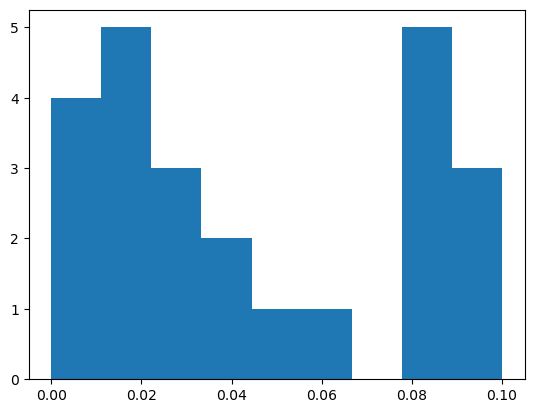

In [99]:
plt.hist(biais, bins=np.linspace(0, 0.1, 10))
plt.show()

In [101]:
biais

array([ 7.16436561e-03,  1.12070568e-01,  2.61573512e-02,  6.11842051e-02,
        1.46994847e-04,  8.86399969e-02,  8.49047378e-02,  4.22976539e-02,
        1.57139599e-02,  1.24866806e-01,  5.53825498e-02,  1.80843044e-02,
        2.61775758e-02,  1.57184284e-02,  2.99748462e-02, -3.50623122e-05,
        1.78178865e-03,  8.84850472e-02,  1.16011888e-01,  2.01828554e-02,
        1.46193564e-01,  8.29934776e-02, -1.19745662e-03,  1.40103057e-01,
        8.82856175e-02,  1.17171727e-01,  9.91354510e-02,  3.96709016e-04,
        4.41911817e-02,  1.52750295e-02,  9.72684920e-02,  8.98113325e-02],
      dtype=float32)

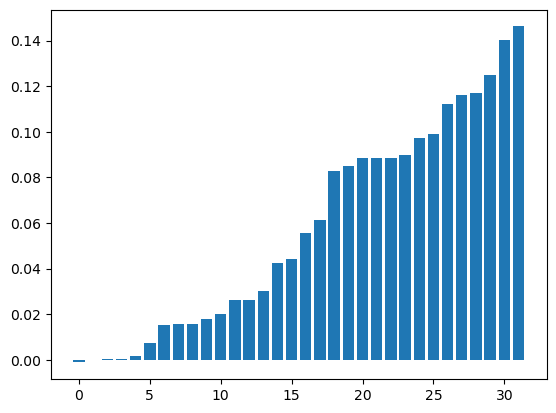

In [103]:
plt.bar(range(len(biais)), sorted(biais))
plt.show()

In [105]:
# Comment comprendre la structure des poids dans les filtres de convolution ?
# tenseur (3,3, 1,32)
filtres = cls.layers[1].weights[0].numpy()
filtres.shape

(3, 3, 1, 32)

In [107]:
filtres[:,:,0, 7]   # un filtre, celui s'indice 7, sur 32
# c'est une petite "fenetre glissante"

array([[-0.01435427,  0.19457829,  0.23982789],
       [-0.12208634, -0.07986184,  0.0269536 ],
       [ 0.15782754,  0.08311056, -0.20542593]], dtype=float32)

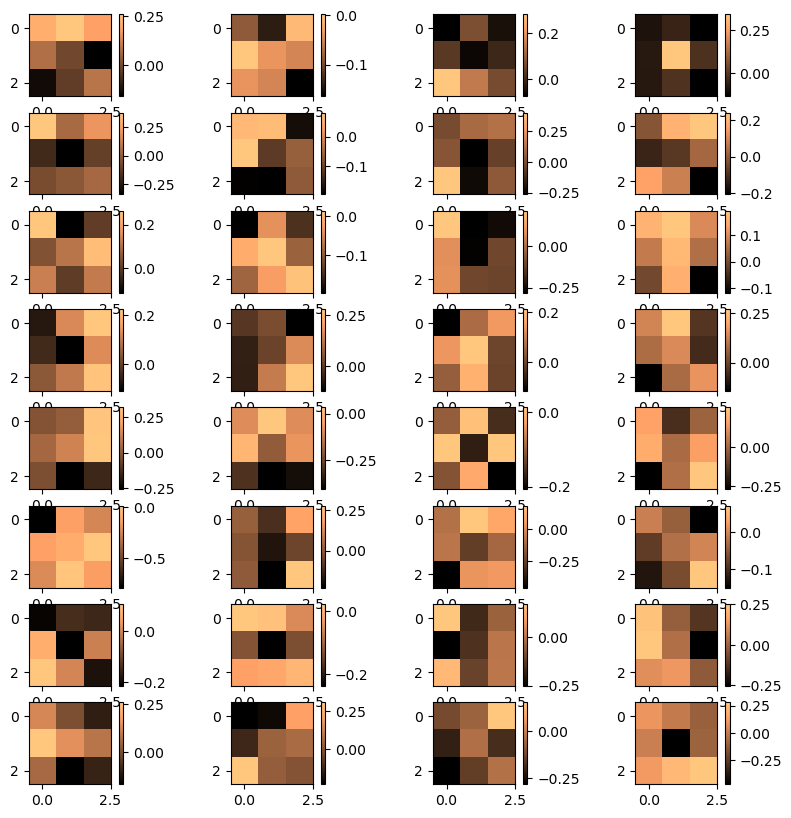

In [111]:
# visualisation de tous les filtres ou "cartes caracteristiques" / features / canaux / noyaux.
plt.figure(figsize=(10,10))
for i in range(32):
    f = filtres[:,:,0,i]
    plt.subplot(8, 4, i+1)    # position dans la grille 8x4
    plt.imshow(f, cmap='copper')
    plt.colorbar()
plt.show()

#### Question 

Comment alors un reseau perçoit un chiffre dans la couche latente ?

In [114]:
encoder = Model(input, x)    # seulement la partie encodeur !

In [116]:
rep_lat = encoder.predict(X_train[3:4, :, :, :])   # juste une image d'entrée 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


In [118]:
rep_lat.shape  # un exemple (=une image d'entrée), 32 filtres (mini-image) de taille 7x7

(1, 7, 7, 32)

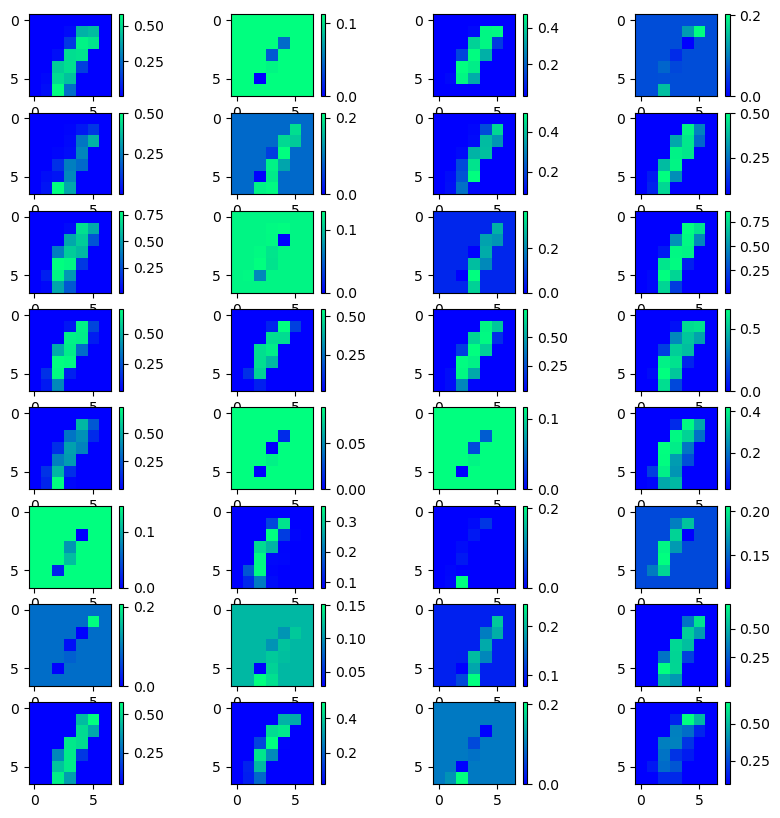

In [120]:
plt.figure(figsize=(10,10))
for i in range(32):
    act = rep_lat[0, :, :, i]   # activation du filtre numero i dans la couche latente
    plt.subplot(8, 4, i+1)
    plt.imshow(act, cmap='winter')
    plt.colorbar()
plt.show()

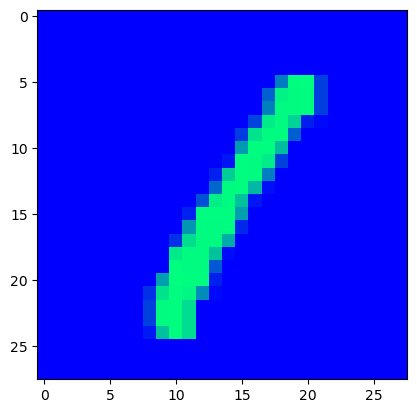

In [122]:
plt.imshow(X_train[3], cmap='winter')
plt.show()

### Remarque 

De toute evidence, les réseaux CNN n'apprennent pas de façon humaine ...

On a d'ailleurs vu que l'apprentissage est assez friables/vulnerable aux attaques adverses)